/var/folders/cg/wkcllzvn1bsf_83d_x7sbljw0000gn/T/ipykernel_15174/2212696463.py:97: RuntimeWarning: overflow encountered in square
  lhVal += ((yt - vbetaNow.T @ vxt) / dsigmau)**2
/var/folders/cg/wkcllzvn1bsf_83d_x7sbljw0000gn/T/ipykernel_15174/2212696463.py:97: RuntimeWarning: overflow encountered in divide
  lhVal += ((yt - vbetaNow.T @ vxt) / dsigmau)**2
/var/folders/cg/wkcllzvn1bsf_83d_x7sbljw0000gn/T/ipykernel_15174/2212696463.py:99: RuntimeWarning: overflow encountered in multiply
  mNablat = vxt * (yt - vbetaNow.T @ vxt)
/var/folders/cg/wkcllzvn1bsf_83d_x7sbljw0000gn/T/ipykernel_15174/2212696463.py:100: RuntimeWarning: invalid value encountered in add
  vbetaNow = vomega + mB * vbetaNow + mA * mNablat.squeeze()
/var/folders/cg/wkcllzvn1bsf_83d_x7sbljw0000gn/T/ipykernel_15174/2212696463.py:97: RuntimeWarning: invalid value encountered in matmul
  lhVal += ((yt - vbetaNow.T @ vxt) / dsigmau)**2
/var/folders/cg/wkcllzvn1bsf_83d_x7sbljw0000gn/T/ipykernel_15174/2212696463.py:99: Runt

Time taken: 50.51 seconds
Time taken: 114.66 seconds


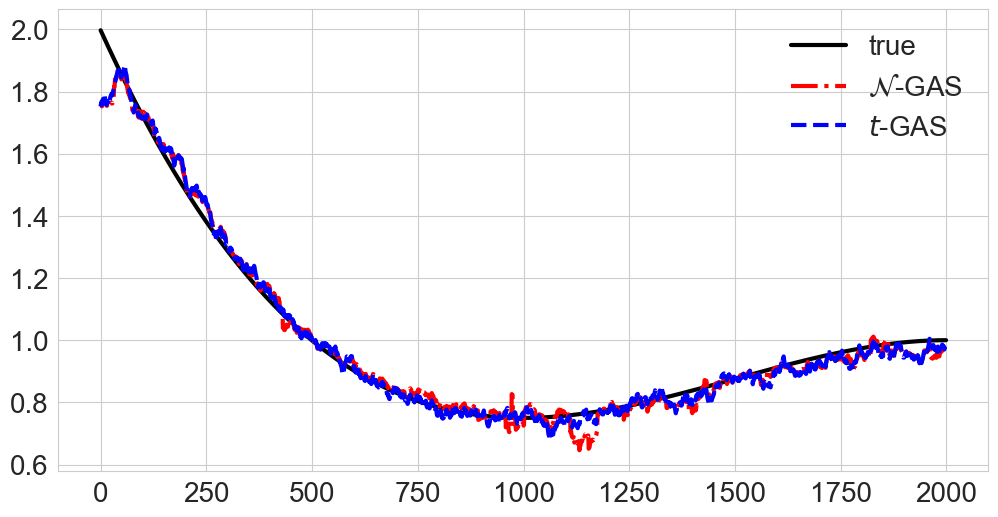

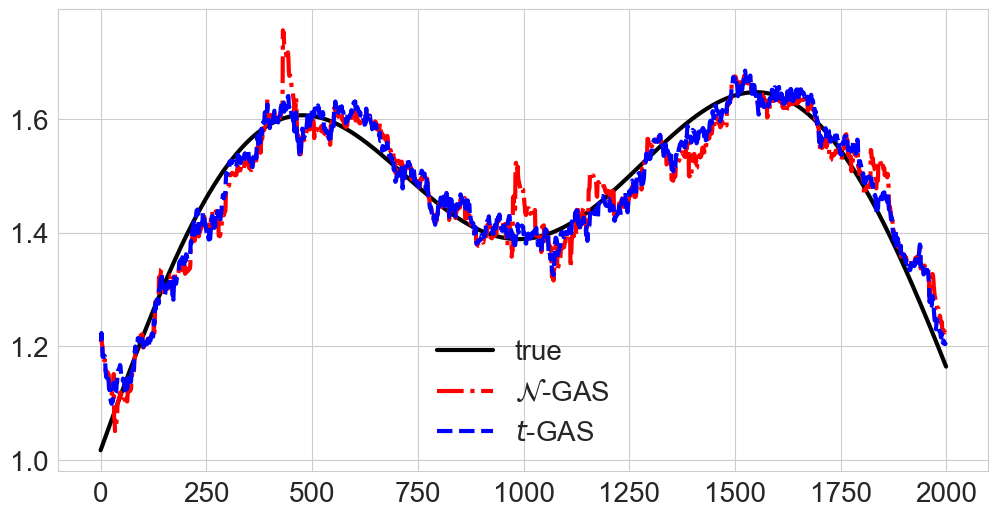

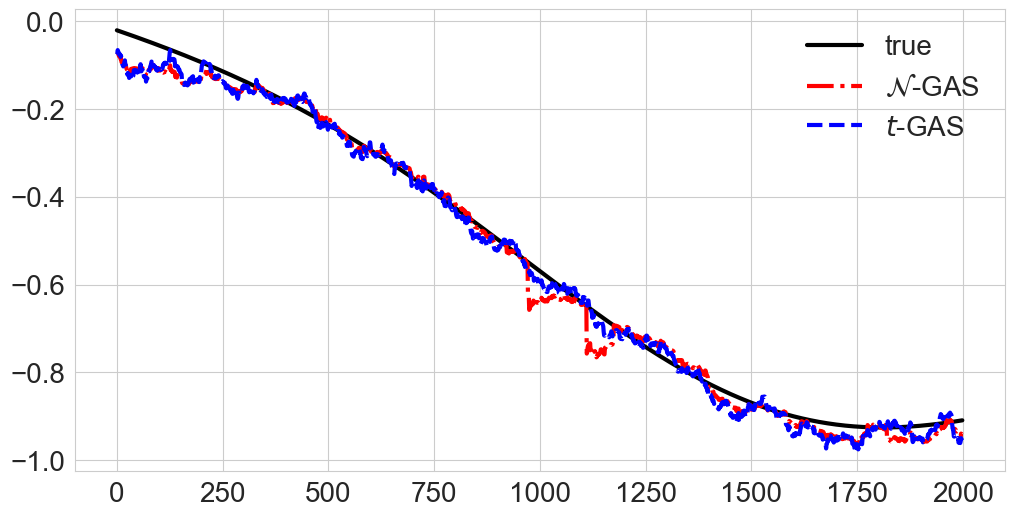

In [71]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.special import gammaln
from scipy.stats import t, multivariate_normal
import time

def score_driven_estimate(vy, mX, vgamma0, method='student'):
    # sample size and #parameters
    dn, dimPara = mX.shape

    # set initial values 
    dnInitial = int(np.ceil(dn / 10))
    vbeta0 = np.linalg.inv((mX[:dnInitial, :]).T @ (mX[:dnInitial, :])) @ ((mX[:dnInitial, :]).T @ vy[:dnInitial])
    LB = np.concatenate(([0.001], -10 * np.ones(dimPara), -np.ones(dimPara), -50 * np.ones(dimPara)))
    UB = np.concatenate(([100], 10 * np.ones(dimPara), np.ones(dimPara), 50 * np.ones(dimPara)))

    options = {'maxfun': 5E5}

    start_time = time.time()

    if method == 'gaussian':  # MLE by Gaussian-GAS
        fgGAS_lh = lambda vpara: -construct_likelihood(vy, mX, dn, dimPara, method, vbeta0, vpara)
        result = minimize(fgGAS_lh, vgamma0, bounds=list(zip(LB, UB)), options=options)
        vparaHat_gGAS = result.x
        vparaHat = vparaHat_gGAS

        # construct betat estimate
        vbetaNow = vbeta0
        mBetaHat_gGAS = np.zeros((dimPara, dn))
        vthetaHat_gGAS = vparaHat_gGAS[1:]
        vomegaHat_gGAS = vthetaHat_gGAS[:dimPara]
        mBHat_gGAS = vthetaHat_gGAS[dimPara:2*dimPara]
        mAHat_gGAS = vthetaHat_gGAS[2*dimPara:]

        for id in range(dn):
            vxt = mX[id, :].reshape(-1, 1)
            yt = vy[id]

            mNablat = vxt * (yt - vbetaNow.T @ vxt)
            vbetaNow = vomegaHat_gGAS + mBHat_gGAS * vbetaNow + mAHat_gGAS * mNablat.squeeze()

            mBetaHat_gGAS[:, id] = vbetaNow

        mBetaHat = mBetaHat_gGAS.T

    elif method == 'student':  # MLE by t-GAS
        LB = np.concatenate(([0.01], LB))
        UB = np.concatenate(([200], UB))
        ftGAS_lh = lambda vpara: -construct_likelihood(vy, mX, dn, dimPara, method, vbeta0, vpara)
        result = minimize(ftGAS_lh, vgamma0, bounds=list(zip(LB, UB)), options=options)
        vparaHat_tGAS = result.x
        vparaHat = vparaHat_tGAS

        # construct betat estimate
        vbetaNow = vbeta0
        mBetaHat_tGAS = np.zeros((dimPara, dn))
        dnuHat_tGAS = vparaHat_tGAS[0]
        dsigmauHat_tGAS = vparaHat_tGAS[1]
        vthetaHat_tGAS = vparaHat_tGAS[2:]
        vomegaHat_tGAS = vthetaHat_tGAS[:dimPara]
        mBHat_tGAS = vthetaHat_tGAS[dimPara:2*dimPara]
        mAHat_tGAS = vthetaHat_tGAS[2*dimPara:]

        for id in range(dn):
            vxt = mX[id, :].reshape(-1, 1)
            yt = vy[id]

            temp1 = (1 + dnuHat_tGAS**(-1)) * (1 + dnuHat_tGAS**(-1) * ((yt - vbetaNow.T @ vxt) / dsigmauHat_tGAS)**2)**(-1)
            mNablat = (1 + dnuHat_tGAS)**(-1) * (3 + dnuHat_tGAS) * temp1 * vxt * (yt - vbetaNow.T @ vxt)
            vbetaNow = vomegaHat_tGAS + mBHat_tGAS * vbetaNow + mAHat_tGAS * mNablat.squeeze()

            mBetaHat_tGAS[:, id] = vbetaNow

        mBetaHat = mBetaHat_tGAS.T

    print(f"Time taken: {time.time() - start_time:.2f} seconds")
    return mBetaHat, vparaHat


def construct_likelihood(vy, mX, dn, dimPara, method, vbeta0, vpara):
    # set initial values 
    vbetaNow = vbeta0
    lhVal = 0

    if method == 'gaussian':
        dsigmau = vpara[0]
        vtheta = vpara[1:]
        vomega = vtheta[:dimPara]
        mB = vtheta[dimPara:2*dimPara]
        mA = vtheta[2*dimPara:]

        for id in range(dn):
            vxt = mX[id, :].reshape(-1, 1)
            yt = vy[id]

            lhVal += ((yt - vbetaNow.T @ vxt) / dsigmau)**2

            mNablat = vxt * (yt - vbetaNow.T @ vxt)
            vbetaNow = vomega + mB * vbetaNow + mA * mNablat.squeeze()

        lhVal = -np.log(dsigmau) - 0.5 * lhVal / dn

    elif method == 'student':
        dnu = vpara[0]
        dsigmau = vpara[1]
        vtheta = vpara[2:]
        vomega = vtheta[:dimPara]
        mB = vtheta[dimPara:2*dimPara]
        mA = vtheta[2*dimPara:]

        for id in range(dn):
            vxt = mX[id, :].reshape(-1, 1)
            yt = vy[id]

            lhVal += ((yt - vbetaNow.T @ vxt) / dsigmau)**2

            temp1 = (1 + dnu**(-1)) * (1 + dnu**(-1) * ((yt - vbetaNow.T @ vxt) / dsigmau)**2)**(-1)
            mNablat = (1 + dnu)**(-1) * (3 + dnu) * temp1 * vxt * (yt - vbetaNow.T @ vxt)
            vbetaNow = vomega + mB * vbetaNow + mA * mNablat.squeeze()

        lhVal = -0.5 * (dnu + 1) * lhVal / dn + gammaln((dnu + 1) / 2) - gammaln(dnu / 2) - 0.5 * np.log(np.pi * dnu) - np.log(dsigmau)

    return lhVal

# Initial setup


# Parameter specification for simulating data
n = 2000
nu = 2.1
burnin = 20
sigmau = 0.1
mA = np.array([[0.3, 0.1], [0.1, 0.2]])

# Simulate data
beta0x = lambda x: -4 * x**3 + 9 * x**2 - 6 * x + 2
beta1x = lambda x: 1.5 * np.exp(-10 * (x - 0.2)**2) + 1.6 * np.exp(-8 * (x - 0.8)**2)
beta2x = lambda x: -0.5 * x - 0.5 * np.exp(-5 * (x - 0.8)**2)
trend = np.arange(1, n + 1) / n
mbeta = np.vstack([beta0x(trend), beta1x(trend), beta2x(trend)]).T

mXi = multivariate_normal.rvs(mean=np.zeros(2), cov=np.eye(2), size=n + burnin).T
mX = np.zeros((2, n + burnin))
for i in range(1, n + burnin):
    mX[:, i] = mA @ mX[:, i - 1] + mXi[:, i]
mX = np.hstack([np.ones((n, 1)), mX[:, -n:].T])
vu = sigmau * t.rvs(nu, size=n)
vy = np.sum(mbeta * mX, axis=1) + vu

# Parameter estimation
dimPara = mX.shape[1]

# MLE by Gaussian-GAS
vdelta0 = 1
vtheta0 = np.concatenate([0.1*np.ones(dimPara),  0.1*np.ones(dimPara),0.1*np.ones(dimPara)])
vgamma0 = np.concatenate([[vdelta0], vtheta0])
mBetaHat_gGAS, vparaHat_gGAS = score_driven_estimate(vy, mX, vgamma0, method='gaussian')

# MLE by t-GAS
vdelta0 = np.array([10, 1])
vtheta0 = np.concatenate([np.ones(dimPara), -0.1 * np.ones(dimPara), 0.1 * np.ones(dimPara)])
vgamma0 = np.concatenate([vdelta0, vtheta0])
mBetaHat_tGAS, vparaHat_tGAS = score_driven_estimate(vy, mX, vgamma0, method='student')

# Make plots
for id2 in range(dimPara):
    plt.figure(figsize=(12, 6))
    plt.plot(mbeta[:, id2], '-k', linewidth=3, label='true')
    plt.plot(mBetaHat_gGAS[:, id2], '-.r', linewidth=3, label='$\\mathcal{N}$-GAS')
    plt.plot(mBetaHat_tGAS[:, id2], '--b', linewidth=3, label='$t$-GAS')
    plt.grid(which='minor')
    plt.legend(fontsize=20, loc='best', frameon=False)
    plt.gca().tick_params(axis='both', which='major', labelsize=20)

    plt.show()
